# 22WSD574 Machine Learning - Principles and Applications for Engineers
## Coursework 2 - Arun Goyal (B911959)

This project uses the [Diabetes Predicition Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) by Mohammed Mustafa from Kaggle. The dataset consists of 9 columns, providing data such as gender, age, BMI, blood glucose levels and a boolean value stating whether the target has diabetes, containing 100,000 entries.

### Project Aims:

### Project Assumptions:

### Project Objectives:
- Identify the most significant risk factors that lead to a diabetes diagnosis
- Use ensemble classification techniques to create a model capable of diagnosing diabetes
  - Implement Random Forest and SVM to achieve this
- Use Feature Engineering to identify distinguish between Type 1 and Type 2 diabetes

---
##### Step 1: Loading and validating the dataset
- The data was loaded into a dataframe with most fields being interpretted as either Float64 or Int64
- `smoking_history` column contained text with possible values `never`, `No Info`, `current`, `former`, `ever` and `not current`. These were enumerated into numerical values to be processed easier by the chosen classification models.
  - `former` and `not current` grouped together as people who have previously smoked but do not currently
  - The category `ever` was unclear and therefore grouped with `No Info`, being enumerated to a value of `NaN`
- The remaining columns were checked for `NaN` values, none having been present within the dataset.
  - As part of this check, columns containing boolean data was cast to a `bool` type to highlight anomalous entries within the dataset. This adjustment was only conducted on the copy dataframe such that numeric values are passed to the classification models.
- The dataset was then split into training and testing sets with a 70/30 split. The features and labels within this were also separated.
  - As the diabetes classification is the intended outcome from the developed model, the diabetes column is used as the data label with all other columns being provided as features.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_csv("diabetes_prediction_dataset.csv")
print(raw_df.dtypes)

# Enumeration of the smoking_history column
def history_enumeration(value):
    if value == "No Info" or value == "ever":
        return np.nan
    elif value == "never":
        return 0
    elif value == "former" or value == "not current":
        return 1
    elif value == "current":
        return 2
    else:
        return 5
raw_df["smoking_history"] = [history_enumeration(x[1]["smoking_history"]) for x in raw_df.iterrows()]

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [3]:
# Scan other dataframe columns for NaN values
nan_check = raw_df[["gender", "age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level", "diabetes"]].copy()
# Convert columns containing boolean values from Integers to Bools
nan_check["hypertension"] = raw_df["hypertension"].astype(bool)
nan_check["heart_disease"] = raw_df["heart_disease"].astype(bool)
nan_check["diabetes"] = raw_df["diabetes"].astype(bool)
print(f"NaN values in the Dataframe: {nan_check.isnull().values.any()}")
nan_check.info()

NaN values in the Dataframe: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  bool   
 3   heart_disease        100000 non-null  bool   
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   diabetes             100000 non-null  bool   
dtypes: bool(3), float64(3), int64(1), object(1)
memory usage: 4.1+ MB


In [4]:
# Splitting of the data into training and testing sets
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(raw_df[["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]], raw_df["diabetes"], test_size=0.3)
train_features.describe()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
count,70000.000000,70000.000000,70000.000000,42069.000000,70000.000000,70000.000000,70000.000000
mean,41.860251,0.074186,0.038300,0.568423,27.329451,5.527599,138.152414
std,22.472797,0.262075,0.191921,0.742563,6.610183,1.071924,40.742939
min,0.080000,0.000000,0.000000,0.000000,10.080000,3.500000,80.000000
25%,24.000000,0.000000,0.000000,0.000000,23.660000,4.800000,100.000000
50%,43.000000,0.000000,0.000000,0.000000,27.320000,5.800000,140.000000
75%,59.000000,0.000000,0.000000,1.000000,29.610000,6.200000,159.000000
max,80.000000,1.000000,1.000000,2.000000,95.220000,9.000000,300.000000


##### Step 2: Visualisation of pre-processed data


In [5]:
raw_df.pivot_table(values=["age", "bmi", "HbA1c_level", "blood_glucose_level"], index=["gender","diabetes"], aggfunc=[np.mean, np.std, min, max])

mean                                             
                HbA1c_level        age blood_glucose_level        bmi   
gender diabetes                                                         
Female 0           5.391509  40.935065          132.811429  27.022526  \
       1           6.939879  60.993499          193.942838  32.623898   
Male   0           5.404354  38.934209          132.908668  26.691107   
       1           6.929512  60.894776          194.262441  31.286467   
Other  0           5.405556  29.555556          139.444444  27.379444   

                        std                                            
                HbA1c_level        age blood_glucose_level       bmi   
gender diabetes                                                        
Female 0           0.972809  21.704353           34.213086  6.611745  \
       1           1.077035  14.903056           58.854519  8.240382   
Male   0           0.969812  23.099105           34.297606  6.006659   
       1           1.076148  14.151224           58.411327  6.656060   
Other  0           1.135767  16.695270           33.380555  6.420016   

                        min                                          max   
                HbA1c_level   age blood_glucose_level    bmi HbA1c_level   
gender diabetes                                                            
Female 0                3.5  0.08                  80  10.01         6.6  \
       1                5.7  4.00                 126  10.98         9.0   
Male   0                3.5  0.08                  80  10.01         6.6   
       1                5.7  3.00                 126  11.91         9.0   
Other  0                3.5  7.00                  80  14.09         6.6   

                                                  
                  age blood_glucose_level    bmi  
gender diabetes                                   
Female 0         80.0                 200  87.70  
       1         80.0                 300  88.72  
Male   0         80.0                 200  95.69  
       1         80.0                 300  83.74  
Other  0         55.0                 200  37.49

<Axes: ylabel='age'>

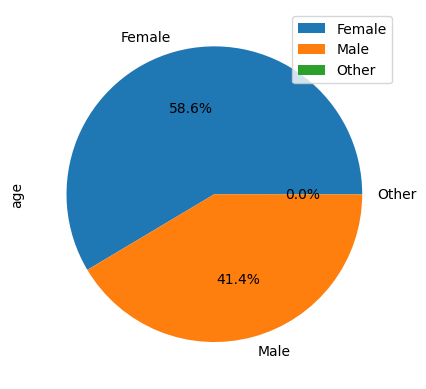

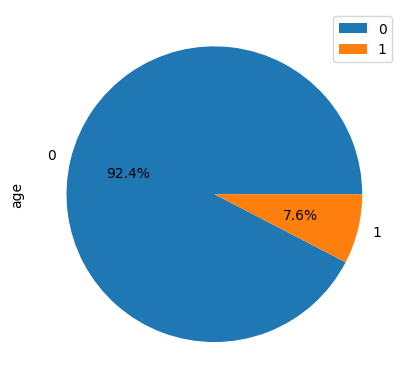

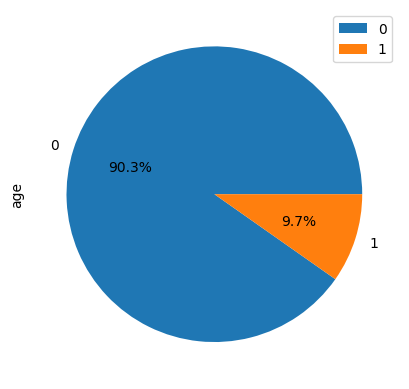

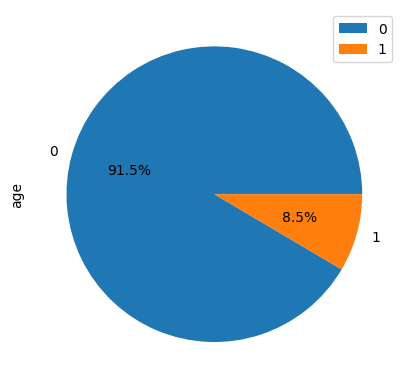

In [36]:
mf_split = raw_df[["gender", "age"]].groupby("gender").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%')

f_split = raw_df[raw_df["gender"] == "Female"]
f_diabetes_split = f_split[["age", "diabetes"]].groupby("diabetes").count()
f_diabetes_split.plot.pie(y="age", autopct='%1.1f%%')

m_split = raw_df[raw_df["gender"] == "Male"]
m_diabetes_split = m_split[["age", "diabetes"]].groupby("diabetes").count()
m_diabetes_split.plot.pie(y="age", autopct='%1.1f%%')

diabetes_split = raw_df[["age", "diabetes"]].groupby("diabetes").count()
diabetes_split.plot.pie(y="age", autopct='%1.1f%%')